## CS431/631 Data Intensive Distributed Analytics
### Winter 2023 - Final Project
---

**Please edit this (text) cell to provide your name and UW student ID number!**
* **Name:** Kyu Min Shim
* **ID:** 20713131

---
#### Overview

For the final project, I will implement the K-means clustering algorithm using map-reduce. Specifically, this K-means implementation is for clustering in images. I will implement two types of clustering - one in which only colors of each pixels are clustered, and another in which both colors and the coordinates of the pixels are clustered. When applying clustering algorithm to images, we group similar pixels into the same bucket and represent them all with their mean color, ultimately reducing the dynamic range of the image (number of distinct color in the image). 

The following block is used to install Spark. The input files used in this notebook are downloaded from `matplotlib` library, but user may pass any image of their choice to the main function to generate clustered output. 

In [ ]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop2.tgz
!tar xf spark-3.3.2-bin-hadoop2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop2"

import findspark
findspark.init()

from pyspark import SparkContext, SparkConf

spark_conf = SparkConf()\
  .setAppName("YourTest")\
  .setMaster("local[*]")

sc = SparkContext.getOrCreate(spark_conf)

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as image
from scipy import misc
import time

<ipython-input-4-5991587ae1ff>:1: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  img = misc.face()


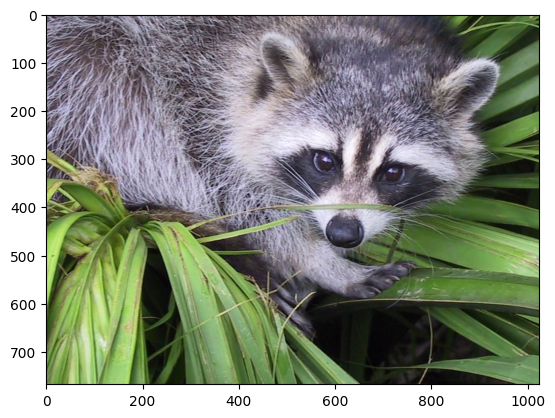

In [ ]:
img = misc.face()
plt.imshow(img)

In [ ]:
# NumPy implementation of kmeans
def kmeans_numpy(img, num_clusters, num_iter):
  # initialize params
  numrows = img.shape[0]
  numcols = img.shape[1]
  k = num_clusters
  no_label = num_clusters

  # initialize cluster means
  means = np.zeros((k, 3),'d')
  poolX = range(numcols)
  poolY = range(numrows)
  init_pixels = np.array([np.random.choice(poolX, k), np.random.choice(poolY, k)]).T
  for label in range(k):
            means[label,:3] = img[init_pixels[label,1],init_pixels[label,0],:3]

  labels = np.full((numrows, numcols), fill_value=no_label)

  for i in range(num_iter):
    # compute labels 
    shape = (numrows,numcols)
    opt_labels = np.full(shape, fill_value=no_label) 
    
    min_dist = np.full(shape, fill_value=np.inf)  
    
    # generate matrices that provide x and y coordinates of each pixels
    col_coord, row_coord = np.meshgrid(range(numcols), range(numrows))
    
    for label in range(k):
        # generate squared RGB distance of all pixels to each cluster 
        full_dist = np.sum(np.square(means[label,:3]-img.astype(float)), axis=2)
        # update min_distance and opt_labels if current cluster is closer than previous closest cluster
        min_dist = np.where(min_dist < full_dist, min_dist, full_dist)
        opt_labels = np.where(min_dist < full_dist, opt_labels, label)

    # update the labels based on opt_labels computed above
    labels = opt_labels

    # generate matrices that provide x and y coordinates of each pixels
    col_coord, row_coord = np.meshgrid(range(numcols), range(numrows))
    
    for label in range(k):
        # if empty cluster, mean values are set to 0
        if label not in labels:
            means[label,:] = np.infty
        # update mean RGB values for each cluster 
        else:
            means[label, :3] = np.mean(img[np.where(labels==label)], axis=0)

  # with cluster labels calculated, calculate the mean color within each cluster and output image
  new_img = np.zeros(img.shape)
  for label in range(k):
    # average all rgb value for each cluster and create clustered image
    new_img[labels == label] = np.mean(img[np.where(labels == label)], axis=0)
  return new_img.astype(int)


In [ ]:
iterations = np.array([1, 5, 10, 20, 50])
clusters = np.array([2, 3, 5, 8, 10])
numpy_times = np.zeros((len(iterations)*len(clusters), 3))

In [ ]:
# generate runtimes for different parameter values 
for i in range(len(iterations)):
  for j in range(len(clusters)):
    start_time = time.time()
    res = kmeans_numpy(img, clusters[j], iterations[i])
    total_time = time.time() - start_time
    numpy_times[5*i+j,] = np.array([iterations[i], clusters[j], total_time])
numpy_times

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


array([[ 1.        ,  2.        ,  0.26615739],
       [ 1.        ,  3.        ,  0.30752468],
       [ 1.        ,  5.        ,  0.57943106],
       [ 1.        ,  8.        ,  0.75474811],
       [ 1.        , 10.        ,  1.06910896],
       [ 5.        ,  2.        ,  1.33560586],
       [ 5.        ,  3.        ,  1.59485459],
       [ 5.        ,  5.        ,  4.56211686],
       [ 5.        ,  8.        ,  4.12858748],
       [ 5.        , 10.        ,  3.66953802],
       [10.        ,  2.        ,  1.5312922 ],
       [10.        ,  3.        ,  1.94388914],
       [10.        ,  5.        ,  3.54893279],
       [10.        ,  8.        ,  4.38409901],
       [10.        , 10.        ,  5.57124043],
       [20.        ,  2.        ,  3.40930915],
       [20.        ,  3.        ,  3.83073568],
       [20.        ,  5.        ,  6.07866573],
       [20.        ,  8.        ,  8.28916645],
       [20.        , 10.        , 11.29395461],
       [50.        ,  2.        ,  7.163

In [ ]:
# PySpark implementation of kmeans
def kmeans_spark(img, num_clusters, num_iter): 
  k = sc.broadcast(num_clusters)
  # read in pixels and flatten them to a list of RGB entries 
  pixels = sc.parallelize(img).flatMap(lambda x: [tuple(px) for px in x])
  # randomly select pixels for intial cluster means and broadcast
  cluster_means = sc.broadcast(np.array(pixels.takeSample(False, k.value, 0)))

  # instead of mapping to entire set of pixels,
  # collect the same colors together and count how many of each unique RGB value there is
  # pre-process pixels by grouping them by the same RGB values 
  # compute distance for each unique RGB to each cluster since all pixels of same rgb would go to same cluster
  # later just use count as denominator to compute mean 
  # since most pixels in images are duplicates of some rgb values, this reduces the size of rdd a lot 
  pixels_grouped = pixels.map(lambda x: (x, 1)).reduceByKey(lambda x, y: x+y).cache()

  # map function to assign pixels to clusters
  def map_pixels(pixel):
    p = pixel[0]
    cmeans = cluster_means.value
    closest = k.value
    min_diff = 256**2 * 3
    for i in range(k.value):
      norm = 0
      # need to change this if want to generalize to grayscale - len(const) is error
      for j in range(len(p)):
        norm += (cmeans[i][j] - p[j])**2
      if norm < min_diff:
        closest = i
        min_diff = norm
    return (closest, pixel)
  
  start_time = time.time()
  avg_rgb = None
  for i in range(num_iter):
    print("iteration {0} begin".format(i))
    iter_time = time.time()
    old_rgb = avg_rgb
    # 1. find closest cluster for each unique pixel
    # 2. scale each unique rgb by the number of pixels that share the same rgb
    # 3. sum up all rgb values that are in the same cluster
    # 4. average the rgb values by the number of pixels in that cluster 
    avg_rgb = pixels_grouped.map(map_pixels) \
                            .map(lambda x: (x[0], (tuple([c * x[1][1] for c in x[1][0]]), x[1][1]))) \
                            .reduceByKey(lambda x,y: ([sum(z) for z in zip(x[0],y[0])], x[1] + y[1])) \
                            .map(lambda x: tuple([z/x[1][1] for z in x[1][0]])).cache()
    # broadcast new cluster means for next iteration
    cluster_means = sc.broadcast(avg_rgb.collect())
    print("iteration {0} completed in: ".format(i), time.time() - iter_time)
    # unload cache from previous iteration
    if old_rgb:
      old_rgb.unpersist()


  # use the calculated averages, build a mask of average rgb value per cluster
  final_means = np.array([list(x) for x in cluster_means.value])
  # matrix to keep and update optimal cluster for each pixel
  opt_labels = np.full((img.shape[0],img.shape[1]), fill_value=num_clusters) 
  # matrix to keep and update minimum distnace to clusters for each pixel
  min_dist = np.full((img.shape[0],img.shape[1]), fill_value=np.inf)  
  for label in range(num_clusters):
      # generate squared RGB distance of all pixels to each cluster 
      rgb_dist = np.sum(np.square(final_means[label,]-img.astype(float)), axis=2)
      # update min_distance and opt_labels if current cluster is closer than previous closest cluster
      min_dist = np.where(min_dist < rgb_dist, min_dist, rgb_dist)
      opt_labels = np.where(min_dist < rgb_dist, opt_labels, label)
  
  new_img = np.zeros(img.shape)
  for label in range(num_clusters):
    # create cluster image by assigning corresponding cluster mean to every pixel
    new_img[opt_labels == label] = final_means[label,]
  print("final image processing complete: ", time.time() - start_time)
  return new_img.astype(int)

In [ ]:
spark_times = np.zeros((len(iterations)*len(clusters), 3))

In [ ]:
# generate runtimes for different parameter values 
for i in range(len(iterations)):
  for j in range(len(clusters)):
    start_time = time.time()
    res = kmeans_spark(img, clusters[j], iterations[i])
    total_time = time.time() - start_time
    spark_times[5*i+j,] = np.array([iterations[i], clusters[j], total_time])
spark_times

iteration 0 begin
iteration 0 completed in:  14.372675657272339
final image processing complete:  14.541222333908081
iteration 0 begin
iteration 0 completed in:  17.572631120681763
final image processing complete:  17.721139669418335
iteration 0 begin
iteration 0 completed in:  18.713395357131958
final image processing complete:  18.95460343360901
iteration 0 begin
iteration 0 completed in:  28.187368631362915
final image processing complete:  28.651191234588623
iteration 0 begin
iteration 0 completed in:  29.130629539489746
final image processing complete:  29.578593730926514
iteration 0 begin
iteration 0 completed in:  14.588167667388916
iteration 1 begin
iteration 1 completed in:  3.5397703647613525
iteration 2 begin
iteration 2 completed in:  4.110450983047485
iteration 3 begin
iteration 3 completed in:  2.6730098724365234
iteration 4 begin
iteration 4 completed in:  3.474067449569702
final image processing complete:  28.564988136291504
iteration 0 begin
iteration 0 completed in:  

array([[  1.        ,   2.        ,  23.35643578],
       [  1.        ,   3.        ,  20.88259411],
       [  1.        ,   5.        ,  21.15020895],
       [  1.        ,   8.        ,  32.18050551],
       [  1.        ,  10.        ,  31.77259135],
       [  5.        ,   2.        ,  30.86720037],
       [  5.        ,   3.        ,  31.29422903],
       [  5.        ,   5.        ,  38.83594155],
       [  5.        ,   8.        ,  48.33240199],
       [  5.        ,  10.        ,  54.00194097],
       [ 10.        ,   2.        ,  45.05381656],
       [ 10.        ,   3.        ,  46.03265882],
       [ 10.        ,   5.        ,  55.36944056],
       [ 10.        ,   8.        ,  71.70564008],
       [ 10.        ,  10.        ,  82.35755587],
       [ 20.        ,   2.        ,  72.24356937],
       [ 20.        ,   3.        ,  83.16317821],
       [ 20.        ,   5.        ,  94.47857499],
       [ 20.        ,   8.        , 119.32619524],
       [ 20.        ,  10.     

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
import random
spark = SparkSession.builder.appName("YourTest").master("local[2]").config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()

In [ ]:
# PySpark ML package implementation of kmeans
def kmeans_spark_ml(img, num_clusters):
  # parallelize image
  img_rdd = sc.parallelize(img).flatMap(lambda x: [px.tolist() for px in x])
  # create input data frame for the KMeans function
  df = spark.createDataFrame(img_rdd, schema = ["r","g","b"])
  vecAssembler = VectorAssembler(inputCols=["r", "g", "b"], outputCol="features")
  input_df = vecAssembler.transform(df)
  kmeans = KMeans(k=num_clusters, seed=1)
  # fit a KMeans model
  model = kmeans.fit(input_df.select("features"))
  transformed = model.transform(input_df)
  # store optimal cluster means
  cluster_means = transformed.select("r","g","b","prediction").groupBy("prediction").avg("r","g","b").toPandas().to_numpy()
  # rid of first column that is the cluster label
  final_means = cluster_means[:,1:]
  
  # matrix to keep and update optimal cluster for each pixel
  opt_labels = np.full((img.shape[0],img.shape[1]), fill_value=num_clusters) 
  # matrix to keep and update minimum distnace to clusters for each pixel
  min_dist = np.full((img.shape[0],img.shape[1]), fill_value=np.inf)  
  for label in range(num_clusters):
      # generate squared RGB distance of all pixels to each cluster 
      rgb_dist = np.sum(np.square(final_means[label,]-img.astype(float)), axis=2)
      # update min_distance and opt_labels if current cluster is closer than previous closest cluster
      min_dist = np.where(min_dist < rgb_dist, min_dist, rgb_dist)
      opt_labels = np.where(min_dist < rgb_dist, opt_labels, label)
  
  new_img = np.zeros(img.shape)
  for label in range(num_clusters):
    # create cluster image by assigning corresponding cluster mean to every pixel
    new_img[opt_labels == label] = final_means[label,]
  return new_img.astype(int)

In [ ]:
spark_ml_times = np.zeros((len(clusters), 2))

In [ ]:
# generate runtimes for different parameter values 
for j in range(len(clusters)):
  start_time = time.time()
  res = kmeans_spark_ml(img, clusters[j])
  total_time = time.time() - start_time
  spark_ml_times[j,] = np.array([clusters[j], total_time])
spark_ml_times

array([[ 2.        , 20.21060014],
       [ 3.        , 23.68678284],
       [ 5.        , 19.40700436],
       [ 8.        , 22.52264547],
       [10.        , 21.42243671]])

Below cells are used to generate all the figures shown in the report. 

In [ ]:
ratio_time = numpy_times.copy()
ratio_time[:,2] = np.divide(numpy_times[:,2], spark_times[:,2])

In [ ]:
numpy_dic1 = {}
for i in range(len(iterations)):
  ni = iterations[i]
  mask = (numpy_times[:,0]==ni)
  numpy_dic1[ni] = numpy_times[mask, :][:,[1,2]]

In [ ]:
spark_dic1 = {}
for i in range(len(iterations)):
  ni = iterations[i]
  mask = (spark_times[:,0]==ni)
  spark_dic1[ni] = spark_times[mask, :][:,[1,2]]

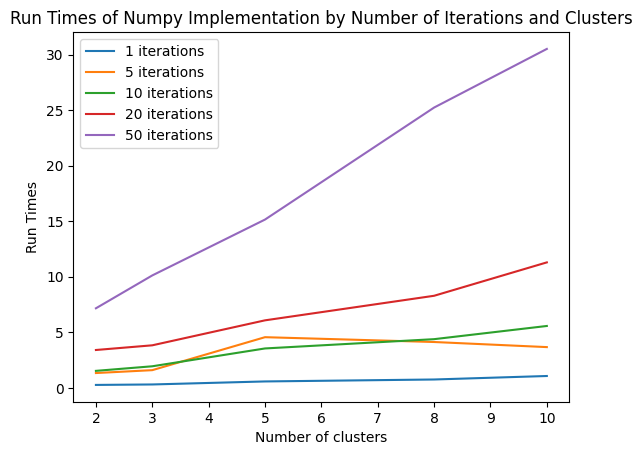

In [ ]:
for i in numpy_dic1:
  plt.plot(numpy_dic1[i][:,0], numpy_dic1[i][:,1], label = str(i) + " iterations")
plt.xlabel("Number of clusters")
plt.ylabel("Run Times")
plt.legend()
plt.title("Run Times of Numpy Implementation by Number of Iterations and Clusters")
plt.show()

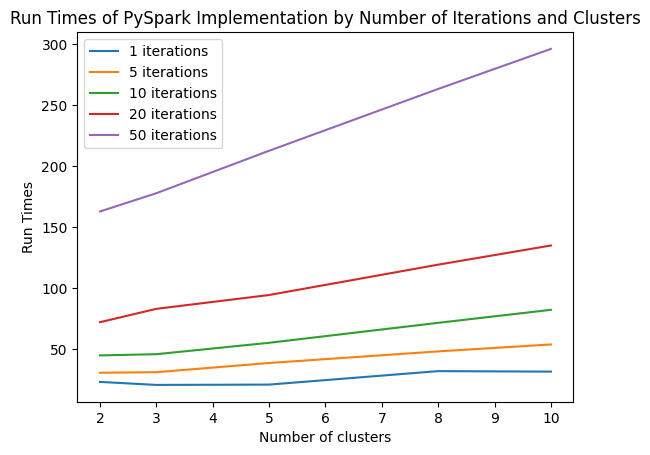

In [ ]:
for i in spark_dic1:
  plt.plot(spark_dic1[i][:,0], spark_dic1[i][:,1], label = str(i) + " iterations")
plt.xlabel("Number of clusters")
plt.ylabel("Run Times")
plt.legend()
plt.title("Run Times of PySpark Implementation by Number of Iterations and Clusters")
plt.show()

In [ ]:
ratio_dic1 = {}
for i in range(len(iterations)):
  ni = iterations[i]
  mask = (ratio_time[:,0]==ni)
  ratio_dic1[ni] = ratio_time[mask, :][:,[1,2]]

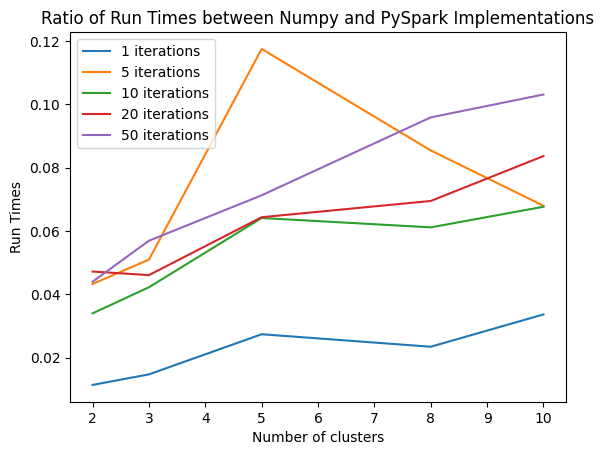

In [ ]:
for i in ratio_dic1:
  plt.plot(ratio_dic1[i][:,0], ratio_dic1[i][:,1], label = str(i) + " iterations")
plt.xlabel("Number of clusters")
plt.ylabel("Run Times")
plt.legend()
plt.title("Ratio of Run Times between Numpy and PySpark Implementations")
plt.show()

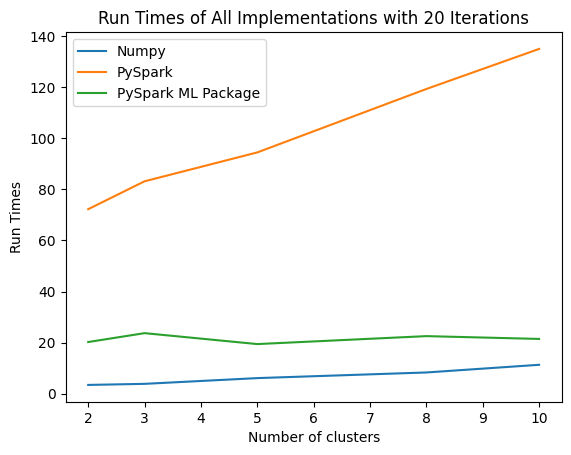

In [ ]:
plt.plot(numpy_dic1[20][:,0], numpy_dic1[20][:,1], label = "Numpy")
plt.plot(spark_dic1[20][:,0], spark_dic1[20][:,1], label = "PySpark")
plt.plot(spark_ml_times[:,0], spark_ml_times[:,1], label = "PySpark ML Package")
plt.xlabel("Number of clusters")
plt.ylabel("Run Times")
plt.legend()
plt.title("Run Times of All Implementations with 20 Iterations")
plt.show()

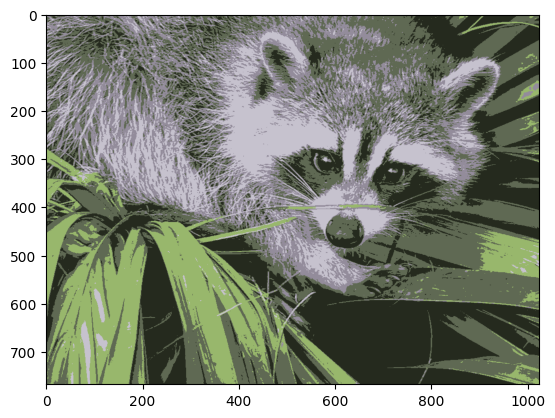

In [ ]:
plt.imshow(kmeans_numpy(img, 5, 10))

iteration 0 begin
iteration 0 completed in:  20.33391571044922
iteration 1 begin
iteration 1 completed in:  4.98231053352356
iteration 2 begin
iteration 2 completed in:  3.3511505126953125
iteration 3 begin
iteration 3 completed in:  3.4874658584594727
iteration 4 begin
iteration 4 completed in:  4.752920866012573
iteration 5 begin
iteration 5 completed in:  4.043613910675049
iteration 6 begin
iteration 6 completed in:  3.199730396270752
iteration 7 begin
iteration 7 completed in:  3.7220547199249268
iteration 8 begin
iteration 8 completed in:  6.537884950637817
iteration 9 begin
iteration 9 completed in:  3.665717840194702
final image processing complete:  58.432618856430054


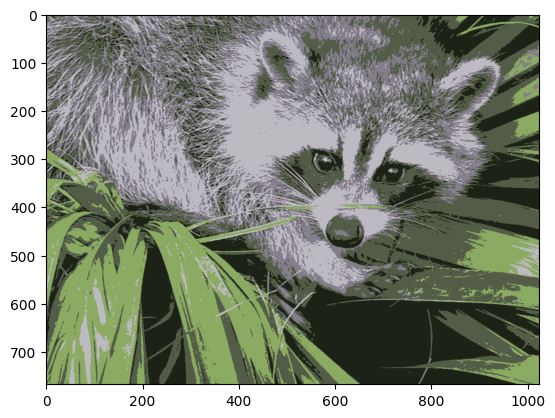

In [ ]:
plt.imshow(kmeans_spark(img, 5, 10))

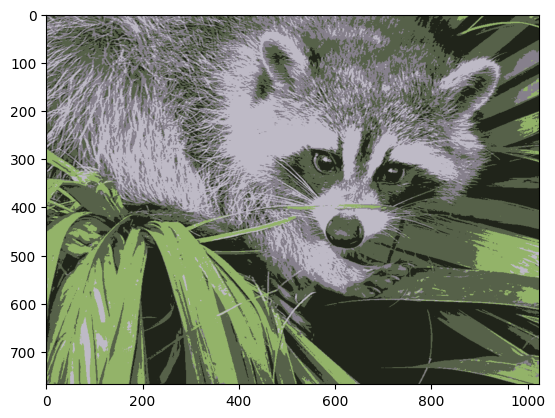

In [ ]:
plt.imshow(kmeans_spark_ml(img, 5))